In [1]:
import os 
import re
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from skimage.measure import compare_psnr
import numpy as np
import argparse
import os
from utlis import *
from tqdm.notebook import tqdm
from inv_models import Generator 
import math
import yaml
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Optimization Code

In [2]:
class MultiOptimizer(torch.nn.Module):
    def __init__(self,configs,z_num,perc_m):
        super().__init__()
        
        self.configs=configs
        self.perc_m=perc_m
        self.z_num=z_num
        device = self.configs['device']
        
        # Load Models 

        gen=Generator(in_channel=256, input_code_dim=512, pixel_norm=True)
        gen.load_state_dict(torch.load(self.configs['ckpt'])["g_ema"], strict=True)

        self.gen=gen.to(device)

        self.init_state()

    def init_state(self):
            
        self.best = None
        self.current_step = 0
        device = self.configs['device']

        perc = self.perc_m / 100
        m = int(perc * (3 * self.configs['image_size'] ** 2))
        ## Make Filters 
        self.indices = torch.tensor(np.random.choice(np.arange(256 * 256 * 3), m, replace=False))
        self.filters = torch.ones((256 *  256 * 3), device=device).normal_().unsqueeze(0).to(device).requires_grad_()
        self.sign_pattern = (torch.rand(256 * 256 * 3) >
                                0.5).type(torch.int32).to(device)
        self.sign_pattern = 2 * self.sign_pattern - 1
        bs = self.configs['batch_size']
        #Make latent codes
        self.latent_z = torch.randn((self.z_num, bs, 512),
                            dtype=torch.float,
                            requires_grad=True, device=device)
        if self.configs['inv_method']=='rtil':
            # Make intermediate distribution based on training algo

            alpha_list=[]
            for _ in range(bs):
                alpha=torch.from_numpy(np.outer(np.random.dirichlet(np.ones(self.z_num)),np.ones(256))).type(dtype=torch.FloatTensor).to(device)
                alpha_list.append(alpha)
            dist=torch.cat(alpha_list,dim=0).reshape(bs,self.z_num,256)

            alpha_list.clear()

            self.alpha=dist.requires_grad_()
        else:
            self.latent_z = torch.randn((self.z_num, bs, 512),
                            dtype=torch.float,
                            requires_grad=True, device=device)
            
            self.alpha=torch.full((bs,self.z_num,256),1/256).to(device).requires_grad_()
        
    def get_lr(self, t, initial_lr, rampdown=0.75, rampup=0.05):
        lr_ramp = min(1, (1 - t) / rampdown)
        lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
        lr_ramp = lr_ramp * min(1, t / rampup)
        return initial_lr * lr_ramp

    def invert_(self,img):
        self.img=img
        learning_rate = self.configs['lr']
        with torch.no_grad():
            var_list = [self.latent_z,self.alpha] 
            
        if self.configs['inv_method']=='rtil':
            optimizer = torch.optim.Adam(var_list, lr=learning_rate)
        else:
             optimizer = torch.optim.SGD(var_list, lr=learning_rate)
            
        pbar = tqdm(range(self.configs['steps']))
        
        mse_min = np.inf
        mse_loss = 0
        reference_loss = 0
        for i in pbar:
            t=i/self.configs['steps']
            lr = self.get_lr(t, learning_rate)
            optimizer.param_groups[0]["lr"] = lr
            img_gen= self.gen(self.latent_z,self.alpha,self.z_num,self.configs)
            loss=0
            
            real_obsv = partial_circulant_torch(img, self.filters, self.indices,self.sign_pattern)
            gen_obsv = partial_circulant_torch(img_gen, self.filters, self.indices,self.sign_pattern)
            
            mse_loss = F.mse_loss(real_obsv,gen_obsv).mean()
            reference_vector = img 
            
            loss += mse_loss
            
            if reference_vector is not None:
                reference_loss = F.mse_loss(img_gen, reference_vector)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (reference_vector is not None) and self.configs['save_on_ref'] and reference_loss < mse_min:
                mse_min = reference_loss
                self.best = img_gen.detach().cpu()
            elif mse_loss < mse_min:
                mse_min = mse_loss
                self.best = img_gen.detach().cpu()
            pbar.set_description(
                (f"mse: {mse_loss:.4f};"
                f" ref: {reference_loss:.4f};"))

    def invert(self,reference_vector=None):
        self.invert_(reference_vector)
        return self.img.cpu().numpy().transpose(0,2,3,1),self.best.cpu().numpy().transpose(0,2,3,1)


## mganprior-RTIL

In [3]:
with open('config.yaml') as f:
    configs = yaml.safe_load(f)
Rtil_configs=configs.get('Rtil')
trans = transforms.Compose([transforms.Resize((Rtil_configs['image_size'])),transforms.ToTensor()])
test_dataset    = datasets.ImageFolder(Rtil_configs['test_set'], transform=trans)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=Rtil_configs['batch_size'],drop_last=False,shuffle=False)
for z_num in Rtil_configs['z_num']:
    print('*'*10,'Number of Latent Codes',z_num,'*'*10)
    for measurements in Rtil_configs['perc_m']:
        original=[]
        recovered=[]
        print('*'*10,'Percentage of Measurements',measurements,'*'*10)
        for i, data in enumerate(test_dataloader):
            multi=MultiOptimizer(Rtil_configs,z_num,measurements)
            img=data[0].to(Rtil_configs['device'])
            org,rec=multi.invert(img)
            original.append(org)
            recovered.append(np.clip(rec,0,1))
            psnr_img=compare_psnr(original[i], recovered[i])
            print('*'*10,'PSNR Per image',psnr_img,'*'*10)
            torch.cuda.empty_cache()
        Original  = np.vstack(original)
        Recovered = np.vstack(recovered)
        print('*'*10,'Percentage of Measurements End of Experiment',measurements,'*'*10)
        psnr      = [compare_psnr(x, y) for x,y in zip(Original, Recovered)]
        print('*'*10,'Percentage of Measurements',measurements,'*'*10)
        print('*'*10,'PSNR',np.mean(psnr),'*'*10)
        original.clear()
        recovered.clear()
        path=Rtil_configs['save_folder']
        if not os.path.exists(path):
            os.makedirs(path)

        np.save(path+"/original.npy", Original)
        np.save(path+"/recovered_"+ str(measurements)+ "%" + ".npy", Recovered)
        np.save(path+"/psnr_" + str(measurements)+ "%" + ".npy",np.mean(psnr))


********** Number of Latent Codes 20 **********
********** Percentage of Measurements 25 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 30.824723870290526 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 33.74145474654517 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 32.580954864432094 **********
********** Percentage of Measurements End of Experiment 25 **********
********** Percentage of Measurements 25 **********
********** PSNR 32.382377827089265 **********
********** Percentage of Measurements 10 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 29.77574593373953 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 32.95356969405254 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 32.47680106426635 **********
********** Percentage of Measurements End of Experiment 10 **********
********** Percentage of Measurements 10 **********
********** PSNR 31.73537223068614 **********
********** Percentage of Measurements 1 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 23.281627398692923 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 26.94111381065094 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 26.45604641229167 **********
********** Percentage of Measurements End of Experiment 1 **********
********** Percentage of Measurements 1 **********
********** PSNR 25.55959587387851 **********


## mganprior 

In [4]:
with open('config.yaml') as f:
    configs = yaml.safe_load(f)
van_configs=configs.get('Vanilla')
trans = transforms.Compose([transforms.Resize((van_configs['image_size'])),transforms.ToTensor()])
test_dataset    = datasets.ImageFolder(van_configs['test_set'], transform=trans)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=van_configs['batch_size'],drop_last=False,shuffle=False)
for z_num in van_configs['z_num']:
    print('*'*10,'Number of Latent Codes',z_num,'*'*10)
    for measurements in van_configs['perc_m']:
        original=[]
        recovered=[]
        print('*'*10,'Percentage of Measurements',measurements,'*'*10)
        for i, data in enumerate(test_dataloader):
            multi=MultiOptimizer(van_configs,z_num,measurements)
            img=data[0].to(van_configs['device'])
            org,rec=multi.invert(img)
            original.append(org)
            recovered.append(np.clip(rec,0,1))
            psnr_img=compare_psnr(original[i], recovered[i])
            print('*'*10,'PSNR Per image',psnr_img,'*'*10)
            torch.cuda.empty_cache()
        Original  = np.vstack(original)
        Recovered = np.vstack(recovered)
        print('*'*10,'Percentage of Measurements End of Experiment',measurements,'*'*10)
        psnr      = [compare_psnr(x, y) for x,y in zip(Original, Recovered)]
        print('*'*10,'Percentage of Measurements',measurements,'*'*10)
        print('*'*10,'PSNR',np.mean(psnr),'*'*10)
        original.clear()
        recovered.clear()
        path=van_configs['save_folder']
        if not os.path.exists(path):
            os.makedirs(path)

        np.save(path+"/original.npy", Original)
        np.save(path+"/recovered_"+ str(measurements)+ "%" + ".npy", Recovered)
        np.save(path+"/psnr_" + str(measurements)+ "%" + ".npy",np.mean(psnr))


********** Number of Latent Codes 20 **********
********** Percentage of Measurements 25 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 28.558298904459946 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 31.7248018987477 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 31.720503047473652 **********
********** Percentage of Measurements End of Experiment 25 **********
********** Percentage of Measurements 25 **********
********** PSNR 30.6678679502271 **********
********** Percentage of Measurements 10 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 28.516202056496482 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 31.63006433661007 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 31.14724403944242 **********
********** Percentage of Measurements End of Experiment 10 **********
********** Percentage of Measurements 10 **********
********** PSNR 30.43117014418299 **********
********** Percentage of Measurements 1 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 23.887395427311844 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 27.46860765924392 **********


  0%|          | 0/2500 [00:00<?, ?it/s]

********** PSNR Per image 26.981479368998734 **********
********** Percentage of Measurements End of Experiment 1 **********
********** Percentage of Measurements 1 **********
********** PSNR 26.112494151851497 **********


## Make Results

In [5]:
def get_psnr_results(direct):
    results={}
    myfiles = [myfile for myfile in os.listdir(direct) if myfile.startswith("psnr")]
    for files in myfiles:
        psnr=np.load(direct + files)
        no_meas=int(re.search(r'\d+', files)[0])
        results[no_meas]=psnr
    return results 

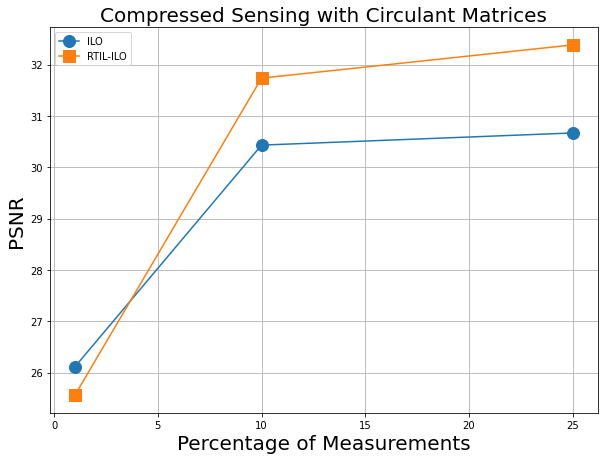

In [6]:
fig = plt.gcf()
fig.set_size_inches(8.5, 6.5)
van_results=get_psnr_results('./results/van/')
rtil_results=get_psnr_results('./results/rtil/')
ilo = sorted(van_results.items(),reverse=True) 
rtil= sorted(rtil_results.items(),reverse=True) 
m, psnr_ilo = zip(*ilo) 
m, psnr_rtil = zip(*rtil) 
plt.plot(m, psnr_ilo,marker='o',markersize=12,label='ILO')
plt.plot(m, psnr_rtil,marker='s',markersize=12,label='RTIL-ILO')
plt.xlabel('Percentage of Measurements',fontsize=20)
plt.ylabel('PSNR',fontsize=20)
plt.legend()
plt.grid()
plt.title('Compressed Sensing with Circulant Matrices',fontsize=20)
plt.tight_layout()
plt.show()